# Polymer Properties Model Refinement

**At this point we diverge from the original publciation thus we acknolwege only the dataset**
Data taken from: Estimation and Prediction of the Polymers’ Physical Characteristics Using the Machine Learning Models Polymers 2024, 16(1), 115; https://doi.org/10.3390/polym16010115.

Github repository: https://github.com/catauggie/polymersML/tree/main

In this notebook we will extend, tune and tweak the methods wlaborated in the Polymers paper with new techniques and optimisations to provide an objectively better fit to the data using some models which may be more appropriate to the specific task.

In [1]:
# Go ahead and import the data into a dataframe and then make sure its imported properly by listing the first few lines
import pandas as pd
new_df = pd.read_excel('Tg_Data_Frame.xlsx')
new_df.head(3)

,Unnamed: 0,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_1015,col_1016,col_1017,col_1018,col_1019,col_1020,col_1021,col_1022,col_1023,Glass transition temperature_value_median
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-60.00
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.39
2,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-24.05


## Function Definitions
Below we define some functions and plots which were not avaliable in the original publication however they give us insights into the performance of each of the algorithms and provide simple visual comparison. 

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA




In [3]:
def evaluate_model_performance(y_test, y_pred):
    """
    Evaluate the performance of a model using various metrics.
    
    Parameters:
    - y_test: array-like of shape (n_samples,) or (n_samples, n_outputs), 
              True values for X.
    - y_pred: array-like of shape (n_samples,) or (n_samples, n_outputs),
              Estimated target values.
    """
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    variance_score = explained_variance_score(y_test, y_pred)
    medae = median_absolute_error(y_test, y_pred)

    print(f'Mean Squared Error: {mse:.3f}')
    print(f'R-squared: {r2:.3f}')
    print(f'Mean Absolute Error: {mae:.3f}')
    print(f'Explained Variance Score: {variance_score:.3f}')
    print(f'Median Absolute Error: {medae:.3f}')

# Example usage:
# y_test = [actual values]
# y_pred = [predicted values]
# evaluate_model_performance(y_test, y_pred)


def plot_actual_vs_predicted(y_test, y_pred):
    """
    Plot the actual vs. predicted values to evaluate a model's performance.
    
    Parameters:
    - y_test: array-like, True values.
    - y_pred: array-like, Predicted values.
    """
    plt.figure(figsize=(10, 6))  # Set the figure size for better readability

    # Scatter plot for actual vs. predicted values
    plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Actual')

    # Ideal line for perfect predictions
    max_val = max(max(y_test), max(y_pred))  # Find the maximum value for setting plot limits
    min_val = min(min(y_test), min(y_pred))  # Find the minimum value for setting plot limits
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='Ideal Fit')

    # Customization and labels
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Model Predictions vs. Actual Data')
    plt.legend()
    plt.grid(True)

    # Show plot
    plt.show()

# Example usage:
# y_test = [actual values]
# y_pred = [predicted values]
# plot_actual_vs_predicted(y_test, y_pred)

def bland_altman_plot(y_test, y_pred):
    """
    Generate a Bland-Altman plot to assess the agreement between two sets of measurements.
    
    Parameters:
    - y_test: array-like, true values.
    - y_pred: array-like, predicted values.
    """
    avg = (y_test + y_pred) / 2
    diff = y_test - y_pred

    plt.figure(figsize=(10, 6))
    plt.scatter(avg, diff, alpha=0.5)
    plt.axhline(y=np.mean(diff), color='r', linestyle='--', label='Mean Difference')
    plt.axhline(y=np.mean(diff) + 1.96 * np.std(diff), color='g', linestyle='--', label='Upper Limit of Agreement')
    plt.axhline(y=np.mean(diff) - 1.96 * np.std(diff), color='g', linestyle='--', label='Lower Limit of Agreement')
    plt.xlabel('Average of Actual and Predicted Values')
    plt.ylabel('Difference Between Actual and Predicted Values')
    plt.title('Bland-Altman Plot')
    plt.legend()
    plt.show()

# Example usage:
# y_test = [actual values]
# y_pred = [predicted values]
# bland_altman_plot(y_test, y_pred)

## Alternative methods
In the scikit-learn library, beyond the models discussed previously, there are several other techniques and tools that could complement or enhance the prediction of glass transition temperatures from molecular fingerprints. While the mentioned models cover a broad range of regression techniques, one alternative approach within scikit-learn that could be particularly useful, especially in the context of enhancing model performance or interpretability, is the use of **ensemble methods** and **pipeline constructions**. Here's a brief overview of these approaches:

### StackingRegressor
- **Overview**: The `StackingRegressor` is an ensemble learning technique that combines multiple regression models via a meta-regressor. The base regressors are fitted on the complete dataset and then the meta-regressor is trained on the outputs of the base regressors as features. This method can leverage the strengths of various models to improve overall prediction accuracy.
- **Application**: For predicting glass transition temperatures, a `StackingRegressor` could combine models like XGBRegressor, RandomForestRegressor, and GradientBoostingRegressor as base learners, with a linear model or another regressor as the meta-learner to fine-tune predictions.

### Pipeline with Feature Selection and Dimensionality Reduction
- **Overview**: Scikit-learn's `Pipeline` allows for the chaining of preprocessing steps (such as feature selection and dimensionality reduction) with a final estimator. This streamlined approach ensures that all preprocessing steps are applied within each cross-validation iteration, preventing data leakage and improving model robustness.
- **Application**: In the case of molecular fingerprints, a pipeline could start with a dimensionality reduction technique (like PCA or SelectFromModel for feature selection) followed by a robust regressor (such as XGBRegressor). This approach can help in managing high-dimensional data and improving model performance by focusing on the most informative features.

### Potential Benefits of Alternative Approaches
- **Improved Performance**: By combining multiple models or applying systematic preprocessing, it's possible to capture complex patterns in the data more effectively, potentially leading to better performance.
- **Reduced Overfitting**: Ensemble methods and pipelines that include feature selection or dimensionality reduction can help in reducing overfitting by introducing regularization or focusing on the most relevant features.
- **Enhanced Interpretability**: While ensemble methods might complicate model interpretability, pipelines that simplify the data or models can make the results easier to understand and explain, especially if simpler models are used at any stage.

### Conclusion
While the individual models discussed previously offer a range of options for predicting glass transition temperatures from molecular fingerprints, employing advanced techniques like `StackingRegressor` or constructing a `Pipeline` for systematic preprocessing and modeling in scikit-learn can further enhance model performance, interpretability, and robustness. These approaches allow for a more nuanced handling of the complexity and high dimensionality inherent in molecular data, potentially leading to more accurate and reliable predictions.

Mean Squared Error: 1953.966
R-squared: 0.841
Mean Absolute Error: 31.641
Explained Variance Score: 0.842
Median Absolute Error: 22.110


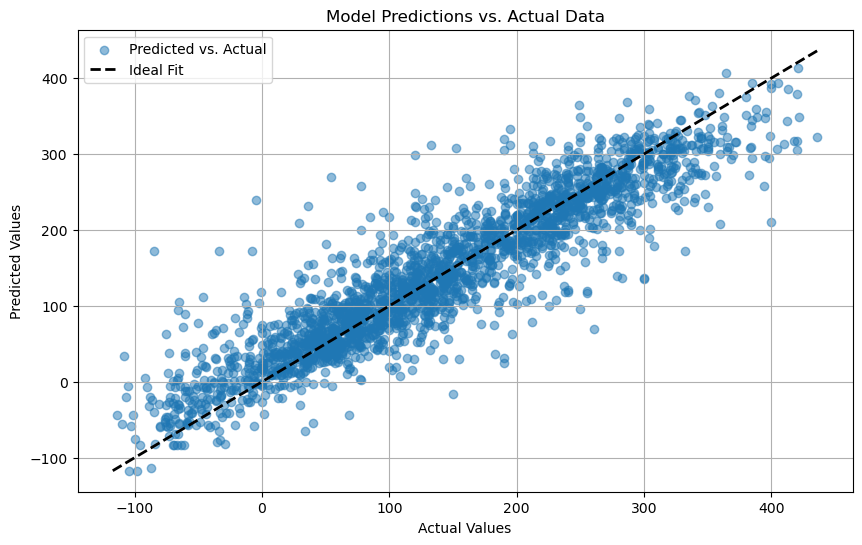

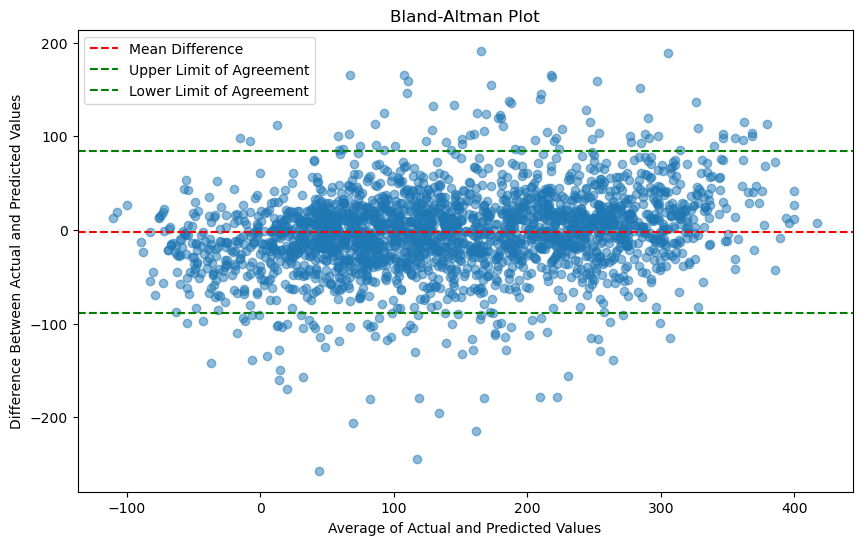

In [4]:
cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define the base models
base_estimators = [
    ('ridge', Ridge()),
    ('dt', DecisionTreeRegressor(random_state=42))
]

# Initialize the Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_estimators,
    final_estimator=LinearRegression()
)

# Train the stacking regressor on the training data
stacking_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = stacking_regressor.predict(X_test)

# Evaluate the model
evaluate_model_performance(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred)
bland_altman_plot(y_test, y_pred)


Mean Squared Error: 2453.124
R-squared: 0.800
Mean Absolute Error: 36.926
Explained Variance Score: 0.801
Median Absolute Error: 27.493


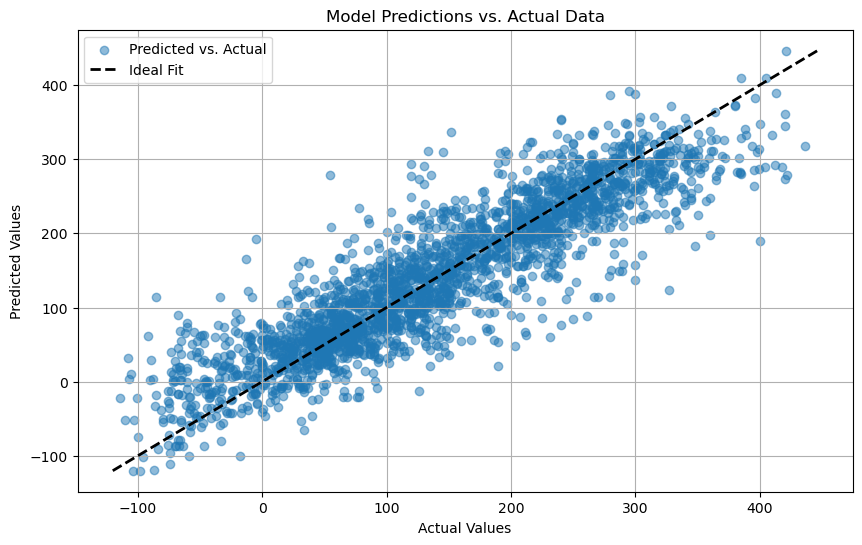

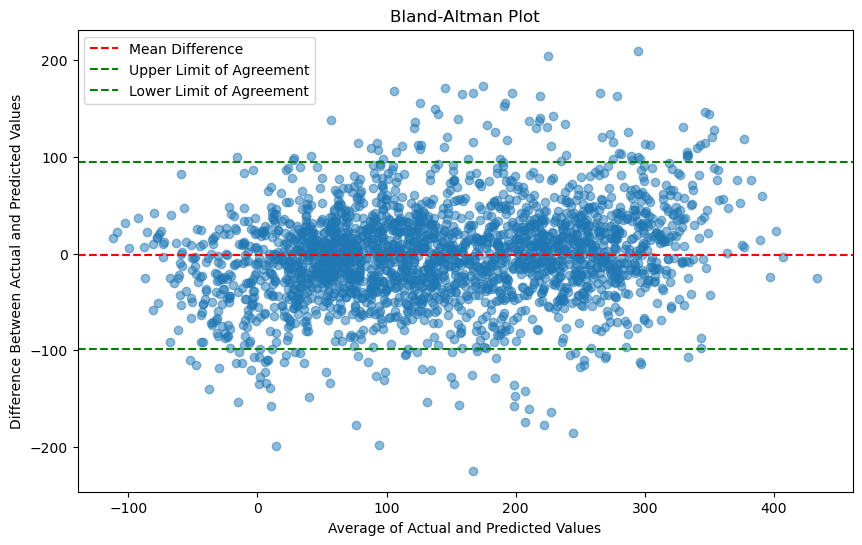

In [5]:
cols = [c for c in new_df.columns if 'col' in c]
X = new_df[cols]
y = new_df['Glass transition temperature_value_median']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Number of features to select
k_features = 'all'  # or set a specific number, e.g., 10

# Define the pipeline steps
pipeline_steps = [
    ('feature_selection', SelectKBest(f_regression, k=k_features)),
    ('dim_reduction', PCA(n_components=0.95)),  # Retain 95% of variance
    ('regressor', LinearRegression())
]

# Initialize the pipeline
pipeline = Pipeline(steps=pipeline_steps)

# Train the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
evaluate_model_performance(y_test, y_pred)
plot_actual_vs_predicted(y_test, y_pred)
bland_altman_plot(y_test, y_pred)
